In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
%matplotlib inline

In [2]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [3]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea

In [4]:
members = ['OAAT'+str(i).zfill(4) for i in range(35)]
members.remove('OAAT0003')

In [5]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
thefiles = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
prod = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')
nmonths = len(prod.time)
yr0 = prod['time.year'][0].values
prod['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [6]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
thefiles = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
step4 = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')

In [144]:
gpp = (24*60*60*month_wts(10)*prod.GPP).groupby('time.year').sum().mean(dim='year').compute() #gC/m2/yr
gpp_step4 = 24*60*60*365*step4.GPP.isel(time=t>31).mean(dim='time').compute()

In [155]:
ee = 1
dgpp      = gpp.sel(ens=ee)-gpp.sel(ens=0)
dgpp_spin = gpp.sel(ens=ee)-gpp_step4.sel(ens=ee)

In [159]:
nx = 20
xv = -80+8*np.arange(nx+1)
out  = np.zeros(nx)
outspin = np.zeros(nx)
for i in range(nx):
    ix = np.logical_and(dgpp>xv[i],dgpp<=xv[i+1])
    out[i] = la.values[ix].sum()
    ix2 = np.logical_and(dgpp_spin>xv[i],dgpp_spin<=xv[i+1])
    outspin[i] = la.values[ix2].sum()
x = 0.5*(xv[1:]+xv[:-1])
d1 = (la/np.nansum(la)*abs(dgpp)).sum(dim='gridcell').values
d2 = (la/np.nansum(la)*abs(dgpp_spin)).sum(dim='gridcell').values

In [160]:
ymax = 1.02*max(max(out),max(outspin))


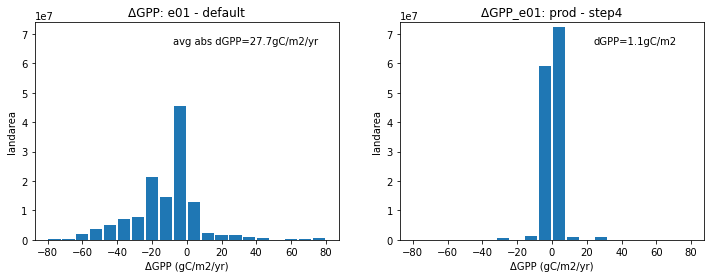

In [162]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.bar(x,out,width=7)
plt.ylabel('landarea')
plt.xlabel(u'ΔGPP (gC/m2/yr)')
plt.ylim([0,ymax])
plt.title(u'ΔGPP: e'+str(ee).zfill(2)+' - default');
plt.text(-0.1*max(xv),0.9*ymax,'avg abs dGPP='+str(np.round(d1,1))+'gC/m2/yr')
plt.subplot(122)
plt.bar(x,outspin,width=7)
plt.ylabel('landarea')
plt.xlabel(u'ΔGPP (gC/m2/yr)')
plt.ylim([0,ymax])
plt.text(0.3*max(xv),0.9*ymax,'dGPP='+str(np.round(d2,1))+'gC/m2')
plt.title(u'ΔGPP_e'+str(ee).zfill(2)+': prod - step4');


In [164]:
i=-1
d1 = np.zeros(33)
d2 = np.zeros(33)
for ee in 1+np.arange(33):
    i+=1
    dgpp      = gpp.sel(ens=ee)-gpp.sel(ens=0)
    dgpp_spin = gpp.sel(ens=ee)-gpp_step4.sel(ens=ee)
    d1[i] = (la/np.nansum(la)*dgpp).sum(dim='gridcell').values
    d2[i] = (la/np.nansum(la)*dgpp_spin).sum(dim='gridcell').values

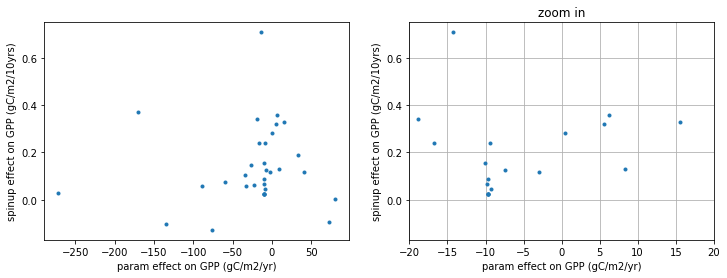

In [166]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on GPP (gC/m2/yr)')
plt.ylabel('spinup effect on GPP (gC/m2/10yrs)')
plt.subplot(122)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on GPP (gC/m2/yr)')
plt.ylabel('spinup effect on GPP (gC/m2/10yrs)')
plt.xlim([-20,20])
plt.title('zoom in')
plt.grid()

### same but for NPP

In [141]:
npp = (24*60*60*month_wts(10)*prod.NPP).groupby('time.year').sum().mean(dim='year').compute() #gC/m2/yr
npp_step4 = 24*60*60*365*step4.NPP.isel(time=t>31).mean(dim='time').compute()

In [142]:
i=-1
d1 = np.zeros(33)
d2 = np.zeros(33)
for ee in 1+np.arange(33):
    i+=1
    d     = npp.sel(ens=ee)-npp.sel(ens=0)
    dspin = npp.sel(ens=ee)-npp_step4.sel(ens=ee)
    d1[i] = (la/np.nansum(la)*d).sum(dim='gridcell').values
    d2[i] = (la/np.nansum(la)*dspin).sum(dim='gridcell').values

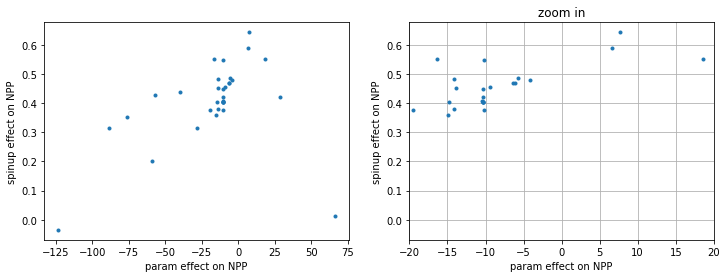

In [143]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on NPP')
plt.ylabel('spinup effect on NPP')
plt.subplot(122)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on NPP')
plt.ylabel('spinup effect on NPP')
plt.xlim([-20,20])
plt.title('zoom in')
plt.grid()

### same, but for TOTECOSYSC

In [137]:
t = step4['time.year']
tec_step4 = step4.TOTECOSYSC.isel(time=t>31).mean(dim='time')
tec       = (month_wts(10)/365*prod.TOTECOSYSC).groupby('time.year').sum().mean(dim='year')

In [138]:
i=-1
d1 = np.zeros(33)
d2 = np.zeros(33)
for ee in 1+np.arange(33):
    i+=1
    d     = tec.sel(ens=ee)-tec.sel(ens=0)
    dspin = tec.sel(ens=ee)-tec_step4.sel(ens=ee)
    d1[i] = (la/np.nansum(la)*d).sum(dim='gridcell').values
    d2[i] = (la/np.nansum(la)*dspin).sum(dim='gridcell').values

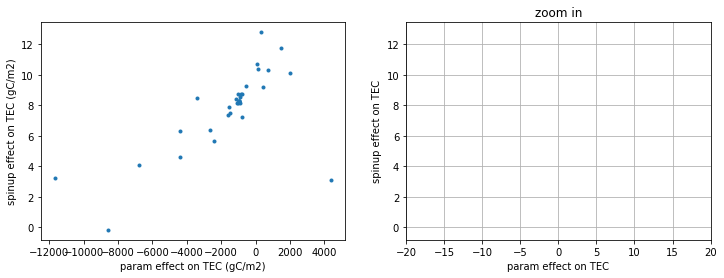

In [140]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on TEC (gC/m2)')
plt.ylabel('spinup effect on TEC (gC/m2)')
plt.subplot(122)
plt.plot(d1,d2,'.')
plt.xlabel('param effect on TEC')
plt.ylabel('spinup effect on TEC')
plt.xlim([-20,20])
plt.title('zoom in')
plt.grid()

In [178]:
tec_glob = (1e-9*(la*tec).sum(dim='gridcell')).compute()

In [198]:
ixlo = []
ixhi = []
for i,member in zip(1+np.arange(33),members[1:]):
    if int(member[-1])%2==1:
        ixlo.append(i)
    else:
        ixhi.append(i)
        

In [217]:
xlo = [1,*3+np.arange(15)]

In [223]:
params =['default','taulnir', 'dleaf', 'tkd_sand', 'bsw_sf', 'n_melt_coef', 'medlynslope', 
         'jmaxb1', 'kmax', 'dbh', 'grperc', 'FUN_fracfixers', 
         'froot_leaf', 'leaf_long', 'tau_cwd', 'k_nitr_max_perday', 'cli_scale', 'vcmaxha']

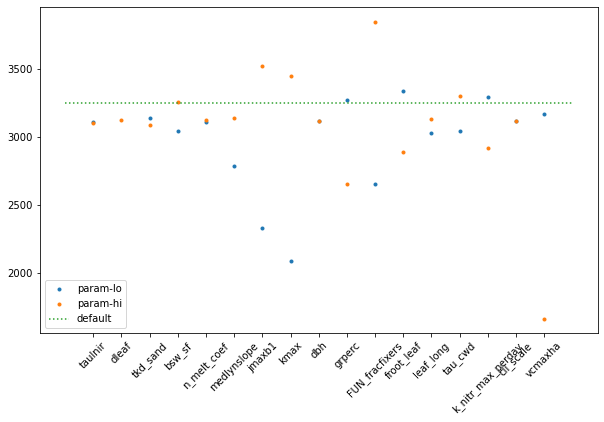

In [230]:
plt.figure(figsize=[10,6])
plt.plot(xlo,tec_glob.isel(ens=ixlo),'.')
plt.plot(1+np.arange(17),tec_glob.isel(ens=ixhi),'.')
tec0 =tec_glob.sel(ens=0)
plt.plot([0,18],[tec0,tec0],':');
plt.legend(['param-lo','param-hi','default'],loc=3)
plt.xticks(1+np.arange(17),params[1:],rotation=45);

In [240]:
gpp_glob = 1e-9*(la*(24*60*60*month_wts(10)*prod.GPP).groupby(
            'time.year').sum().mean(dim='year')).sum(dim='gridcell').compute()

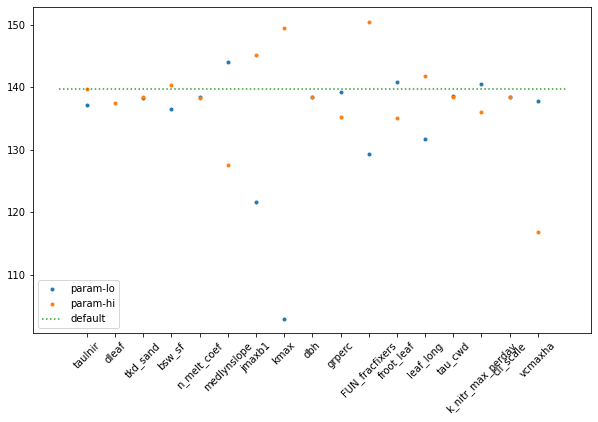

In [241]:
plt.figure(figsize=[10,6])
plt.plot(xlo,gpp_glob.isel(ens=ixlo),'.')
plt.plot(1+np.arange(17),gpp_glob.isel(ens=ixhi),'.')
gpp0 =gpp_glob.sel(ens=0)
plt.plot([0,18],[gpp0,gpp0],':');
plt.legend(['param-lo','param-hi','default'],loc=3)
plt.xticks(1+np.arange(17),params[1:],rotation=45);

In [242]:
npp_glob = 1e-9*(la*(24*60*60*month_wts(10)*prod.NPP).groupby(
            'time.year').sum().mean(dim='year')).sum(dim='gridcell').compute()

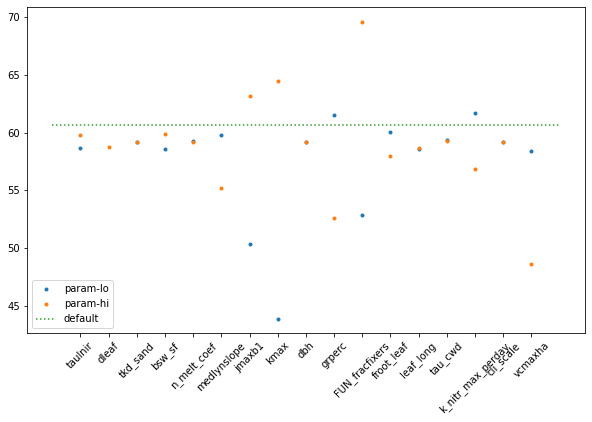

In [243]:
plt.figure(figsize=[10,6])
plt.plot(xlo,npp_glob.isel(ens=ixlo),'.')
plt.plot(1+np.arange(17),npp_glob.isel(ens=ixhi),'.')
npp0 =npp_glob.sel(ens=0)
plt.plot([0,18],[npp0,npp0],':');
plt.legend(['param-lo','param-hi','default'],loc=3)
plt.xticks(1+np.arange(17),params[1:],rotation=45);